## Initial Cleaning and Exploration

In [1]:
%matplotlib inline
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
df = pd.read_csv("top250-00-19.csv")
df.head()

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


In [2]:
#mean age of players in the data
rows = df.shape[0]
age_sum = sum(df['Age'])
mean_age = age_sum / rows
print(mean_age)

24.33872340425532


In [3]:
print(rows)

4700


In [4]:
most_expensive = df[df['Transfer_fee'] == df['Transfer_fee'].max()]
most_expensive

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
4211,Neymar,Left Winger,25,FC Barcelona,LaLiga,Paris SG,Ligue 1,2017-2018,100000000.0,222000000


I've loaded in the dataset and done some initial exploration here. Not surprisingly, Neymar's transfer to PSG is the most expensive one in the dataset.

In [5]:
mean_fee=df.groupby('Team_to')['Transfer_fee'].mean().rename('Mean_fee')
count_transfers=df.groupby('Team_to')['Transfer_fee'].size().rename('Transfer_count')
biggest_avg_spender = pd.concat([mean_fee, count_transfers], axis=1).reset_index()
biggest_avg_spender.nlargest(10, 'Mean_fee')

,Team_to,Mean_fee,Transfer_count
257,SIPG,2.598333e+07,6
110,FC Barcelona,2.390057e+07,70
70,CC Yatai,2.330000e+07,1
194,Man Utd,2.303631e+07,65
243,Real Madrid,2.240867e+07,75
221,Paris SG,1.931485e+07,66
192,Man City,1.915447e+07,94
83,Chelsea,1.896510e+07,96
165,Juventus,1.690736e+07,87
184,Liverpool,1.661671e+07,85


The top ten largest average spenders are shown above. SIPG and CC Yatai are both Chinese clubs that I'm not very familiar with, but their transfer count also isn't that high so I won't look into their inclusion too much. Besides those two clubs, there aren't really any surprises in this list.

In [6]:
league_to = df['League_to']
count = league_to.value_counts()
count['other'] = sum(count[11:])
count.sort_values(ascending=False)
filtered_counts = count[count > 72]
filtered_counts.rename('League')
#Counts of what leagues transfers go to

Premier League    1256
Serie A            739
LaLiga             525
1.Bundesliga       422
Ligue 1            397
Premier Liga       328
Süper Lig          143
Liga NOS           127
Super League       122
Eredivisie         108
other              461
Name: League, dtype: int64

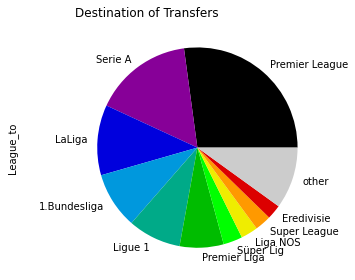

In [7]:
colormap = plt.cm.nipy_spectral
filtered_counts.plot(kind="pie", colormap=colormap, title="Destination of Transfers")
left, right = plt.xlim()
plt.xlim(left - 0.5, right - 0.5)
plt.tight_layout()
plt.show()


In [8]:
league_from = df["League_from"]
count = league_from.value_counts()
count['other'] = sum(count[11:])
count.sort_values(ascending=False)
filtered_counts = count[count > 100]
filtered_counts.rename('League')
#Counts of what leagues transfers come from

Premier League     608
Serie A            602
Ligue 1            428
LaLiga             418
1.Bundesliga       265
Série A            199
Championship       197
Eredivisie         190
Liga NOS           178
Premier Liga       169
Super League       108
other             1338
Name: League, dtype: int64

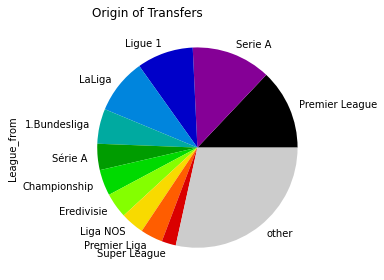

In [9]:
colormap = plt.cm.nipy_spectral
filtered_counts.plot(kind="pie", colormap=colormap, title="Origin of Transfers")
left, right = plt.xlim()
plt.xlim(left - 0.5, right - 0.5)
plt.tight_layout()
plt.show()

The two pie charts above show the destination and origin of the transfers. The first chart shows that the majority of the most expensive transfers go to the traditional top 5 leagues, with the premier league having the greatest percentage. The second pie chart shows the origin of the transfers is similar to the destinations, except that the smaller leagues take up a greater percentage. This makes sense logically, as while many top clubs buy players from other top leagues, they also frequently buy players from smaller leagues. However, it is less common for a club from a smaller league to buy a player from a top league.

## Aggregating Positions

Now I do some more data cleaning. There are many similar positions listed in the dataset, so I am going to group similar positions together, such as Left-Winger and Left-Midfielder in order to get a simpler dataset with less different positions.

In [10]:
#Now we will explore the average cost based on position
df['Position'].value_counts()

Centre-Forward        1218
Centre-Back            714
Central Midfield       487
Attacking Midfield     426
Defensive Midfield     411
Right Winger           305
Left Winger            267
Left-Back              225
Right-Back             181
Goalkeeper             180
Second Striker         130
Left Midfield           87
Right Midfield          63
Forward                  3
Sweeper                  1
Defender                 1
Midfielder               1
Name: Position, dtype: int64

In [11]:
#Clean the data to group similar positions together
df.loc[df.Position == 'Left Winger', 'Position'] = 'Left Midfield'
df.loc[df.Position == 'Second Striker', 'Position'] = 'Centre-Forward'
df.loc[df.Position == 'Right Winger', 'Position'] = 'Right Midfield'
df.loc[df.Position == 'Sweeper', 'Position'] = 'Centre-Back'
df.loc[df.Position == 'Defender', 'Position'] = 'Centre-Back'
df.loc[df.Position == 'Midfielder', 'Position'] = 'Central Midfield'
df.loc[df.Position == 'Forward', 'Position'] = 'Centre-Forward'
df['Position'].value_counts()

Centre-Forward        1351
Centre-Back            716
Central Midfield       488
Attacking Midfield     426
Defensive Midfield     411
Right Midfield         368
Left Midfield          354
Left-Back              225
Right-Back             181
Goalkeeper             180
Name: Position, dtype: int64

In [12]:
average_costs = df.groupby('Position', as_index=False)['Transfer_fee'].mean()
print(average_costs)

             Position  Transfer_fee
0  Attacking Midfield  9.824178e+06
1    Central Midfield  1.007787e+07
2         Centre-Back  8.430929e+06
3      Centre-Forward  9.496869e+06
4  Defensive Midfield  8.992019e+06
5          Goalkeeper  7.622667e+06
6       Left Midfield  1.138398e+07
7           Left-Back  7.718933e+06
8      Right Midfield  1.115549e+07
9          Right-Back  8.254309e+06


In [13]:
df.to_csv('cleaned.csv')